# Ensamble based inversion

In this exercise our goal is to learn about the subsurface properties of the ground at specific location. The property of interest is the seismic wave slowness, denoted $x$. This property will be estimated for 50 differents depths below the ground: 51 meters, 52 meters, ... 100 meters. We let $x_j$ denote the slowness at depth $d_j=j+50$.

The ensemble Kalman filter will be used to estimate the slowness at each depth. This is done by assigning a prior model for the slowness, and using a set of measurements of the travel time data, $\boldsymbol{t}$, where $t_j$ denotes the time it takes for a wave emitted  at ground level to reach a sensor at depth $d_j=j+50$. However, the measurements are not taken directly above the sensor, but 40 meters further away. 

The prior model assigned for the slowness $\boldsymbol{x}$ is Gaussian with parameters 
\begin{equation}
\mu_i = 0.5-0.0001\cdot i
\end{equation}
and 
\begin{equation}
\text{Corr}(x_i,x_i')=\sigma^2(1+\eta h_{i,i'})exp(-\eta h_{i,i'}), 
\end{equation}
where $h_{i,i'}=|i-i'|$, $\eta=0.1$ and $\sigma=0.05$.

If we assume that the wave emitted at ground level follows a straight line, we obtain the following likelihood model
\begin{equation}
t_j = \frac{\sum_{i=1}^{d_j}x_i} {\cos(\theta_j)}+\epsilon_j, \theta_j = \arctan(40/d_j), 
\end{equation}
where $\epsilon_j\sim N(0,\tau^2)=N(0,0.1^2)$.
We will now sample $B=200$ independent realizations (called ensemble members) from the prior distribution, and sequentially assign each ensemble member to each data point $t_j$. 
The ensemble members will be denoted $x^b, b = 1, \dots, B$.
The procedure is as follows:

Calculate $t_j^b$ using the equation for $t_j$ above, for each ensemble member $x_b$.

Calculate the empirical covariances $\Sigma_{x,t_j}$, where the ith element of $\Sigma_{x,t_j}$ is computed as follows:
\begin{equation}
(\Sigma_{x,t_j})_i = \frac{1}{B-1}\sum_{b=1}^B(t^b_j-\bar{t_j})(x^b_i-\bar{x_i}),
\end{equation}
where $\bar{t_j}=\frac{1}{B} \sum_{b=1}^B t^b_j$ and $\bar{x_i}=\frac{1}{B} \sum_{b=1}^B x^b_i$.

Calculate 
\begin{equation}
\sigma^2_{t_j} = \frac{1}{B-1}\sum_{b=1}^B(t^b_j-\bar{t_j})^2.
\end{equation}

Calculate the Kalman gain, $K$: $K = \Sigma_{x, t_j}/\sigma^2_{t_j}$.

Assimilate each ensemble member:
\begin{equation}
x^b = x^b + K(t_j-t^b_j).
\end{equation}
Repeat this sequentially, either by iterating through the data forwards ($j = 1, \dots, 50$) or backwards$ (j=50, \dots , 1$).


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
sns.set_style("white")

In [2]:
t = np.loadtxt("https://folk.ntnu.no/joeid/emnemodul/traveltimedata.txt")
data = pd.DataFrame({'receiver_layer': np.linspace(51,100,50), 
                     'travel_time': t})

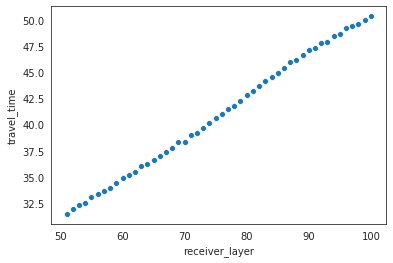

In [3]:
sns.scatterplot(x = "receiver_layer",
                         y = "travel_time",
                         data=data)

The plot above illustrates our given data points, where the differents depths are shown along the $x$-axis.  

# a)

In [4]:
def create_ensemble(B, n):
    mu = 0.5-0.001*np.linspace(1,n,num = n)
    eta = 0.1
    sigma = 0.05
    covar = np.identity(n)*sigma**2
    for i in range(n-1):
        for j in range(i+1,n):
            h = abs(i-j)
            covar[i,j] = covar[j,i] = (sigma**2)*(1+(eta*h))*np.exp(-eta*h)
    return(mu,covar)

def r_x(mu,covar,B,n):
    x = np.zeros((B,n))
    L = linalg.cholesky(covar).transpose()
    for b in range(B):
        x[b,:] = mu + L@np.random.normal(0, 1, n)
    return(x)


def forecast_ensemble(t, B, n, direction):
    mu, covar = create_ensemble(B,n)
    x = r_x(mu, covar, B, n)
    theta = np.cos(np.arctan(40/np.linspace(51,n,50)))
    t_for = np.zeros(B)
    x_asim = np.zeros((B,n,4))
    x_asim[:,:,0] = x
    count = 1
    tau = 0.1
    if direction == 1:
        iteration = range(50)
    elif direction == -1:
        iteration = range(49,-1,-1)
    for j in iteration:
        
        sigma = np.zeros(n)
        K = np.zeros(n)
        for b in range(B):
            t_for[b] = sum(x[b,0:(j+51)])/theta[j] + np.random.normal(0,tau)
        mu_t = np.mean(t_for)
        dif_t = t_for - mu_t
        var_t = np.transpose(dif_t)@dif_t
        mu_x = x.mean(axis = 0)
        
        for i in range(n):
            sigma[i] = np.transpose(dif_t)@(x[:,i]-mu_x[i])
        K= sigma/var_t
        for b in range(B):
            x[b,:] = x[b,:] + K*(t[j] - t_for[b])
        if (j == 0) or (j == 24) or (j==49):
            x_asim[:,:,count] = x
            count += 1
    return(x_asim) 
  
    
def plot_asim(x):
    plt.figure(figsize = (21,7))
    plt.subplot(141)
    plt.plot(x_asim[:,:,0].transpose())
    plt.subplot(142)
    plt.plot(x_asim[:,:,1].transpose())
    plt.subplot(143)
    plt.plot(x_asim[:,:,2].transpose())
    plt.subplot(144)
    plt.plot(x_asim[:,:,3].transpose())
    plt.show()

We will now plot the ensemble members before and after they are assimilated to the data points $t_j$, and also during the assimilation process.

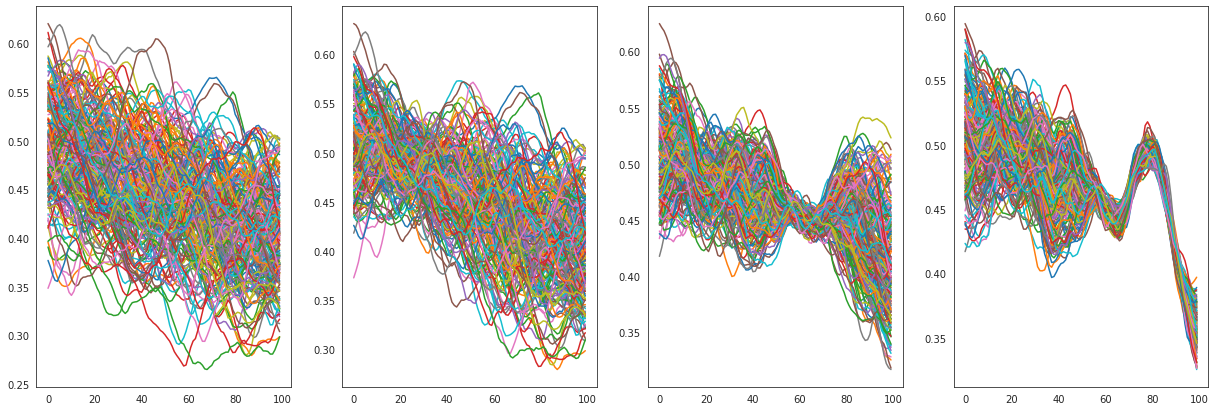

In [5]:
B = 200
n = 100
x_asim = forecast_ensemble(t,B,n,1)
plot_asim(x_asim)

The leftmost plot shows the ensemble members before they are assimilated to the data points $t$. We observe no specific pattern; the ensemble members $\mathbf{x}^b, b=1, \dots , B$ appear to be random. In the second plot, the ensemble has been assimilated to the first data point $t_{51}$. We do not observe any major changes in the ensemble members. This might indicate that it takes some time before the ensemble are affected by data points.

For the third figure, the ensemble members appear to be very similar in the interval around depth $[60,70]$ meters. This is due to the fact that we have conditioned on the data points from 51 meters to 75 meters, and thus the ensemble members have been assimilated to these data points. 

For the rightmost plot, we observe that the ensemble have been assimilated to all of the data points between 51 meters and 100 meters. Thus, the ensemble members appear to be very similar in this area. 

We now want to iterate over the data points backwards; i.e. assimilate the ensemble members to data point $t_{100}, t_{99}, \dots , t_{51}$ rather than forwards: $t_{51}, \dots , t_{100}$.

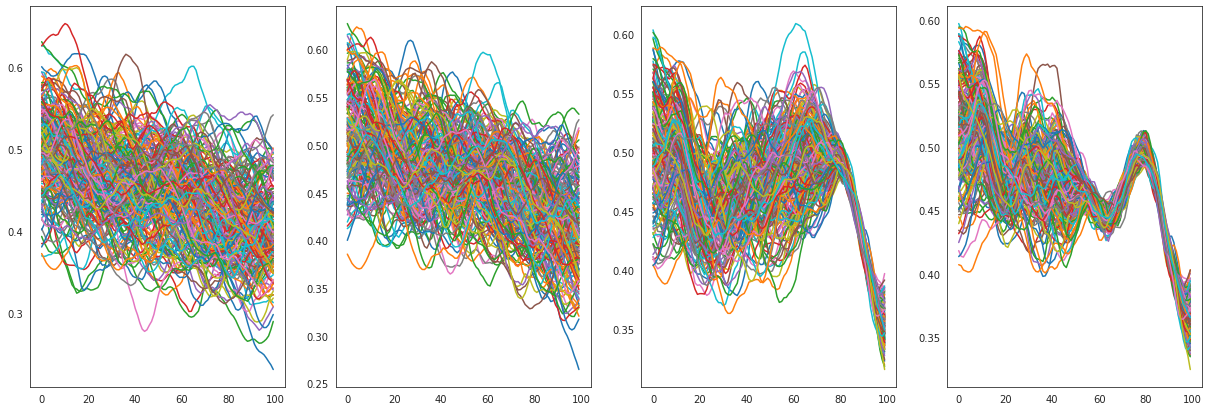

In [6]:
B = 200
x_asim = forecast_ensemble(t,B,n,-1)
plot_asim(x_asim)



The leftmost plot look very similar to the leftmost plot in the forward assimilations. This is not very surprising: neither of them have been assimilated to any data points. 

As for the forward iterations, we do not observe any large differences between the second plot and the first. This is not very surprising, since the ensemble only has been assimilated to $t_{100}$. 

We notice that the third plot is quite different from the third plot above. The ensemble members have only been assimilated to the last 25 observations. 

In the rightmost plot, the ensemble members have been assimilated to all 50 observations, however in the opposite order than in the case above. We see that the ensemble look quite similar to the one in the forward iterations. 

# b)

We now want to vary the ensemble size $B$ and the assimilation order, and see how this affects our results. 

First, we look at the forward and backward assimilations for $B=50$.

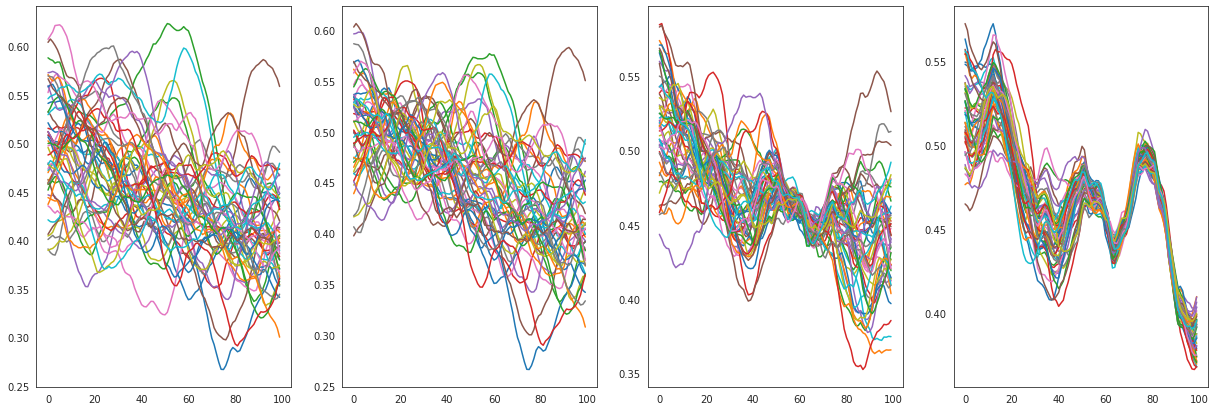

In [7]:
B = 50
x_asim = forecast_ensemble(t,B,n,1)
plot_asim(x_asim)

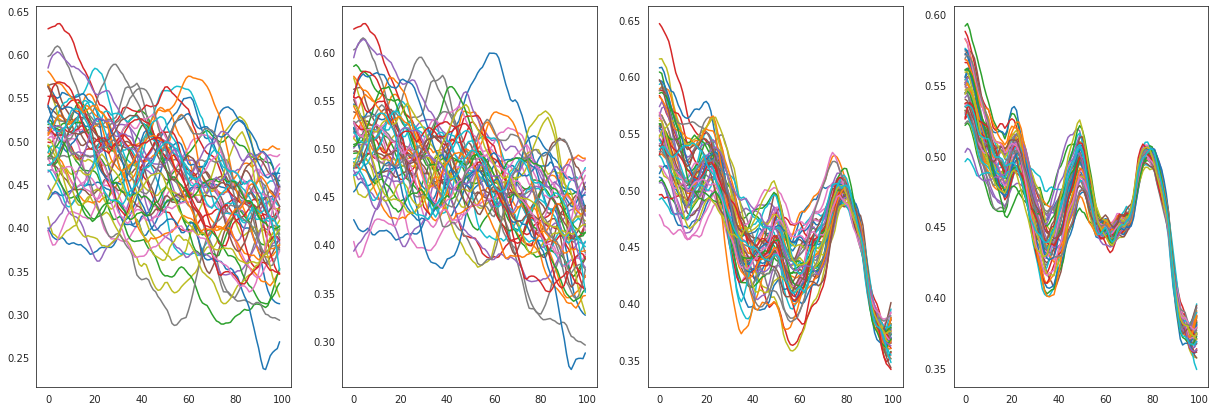

In [8]:
B = 50
x_asim = forecast_ensemble(t,B,n,-1)
plot_asim(x_asim)

We notice that the ensembles look very different from seed to seed. This can be explained by the fact that the Kalman gain, $K$, is based on a small ensemble, and thus each individual ensemble member have a large impact on the estimates. 

Now we set $B=400$, and see how this affects our predictions of $x$.


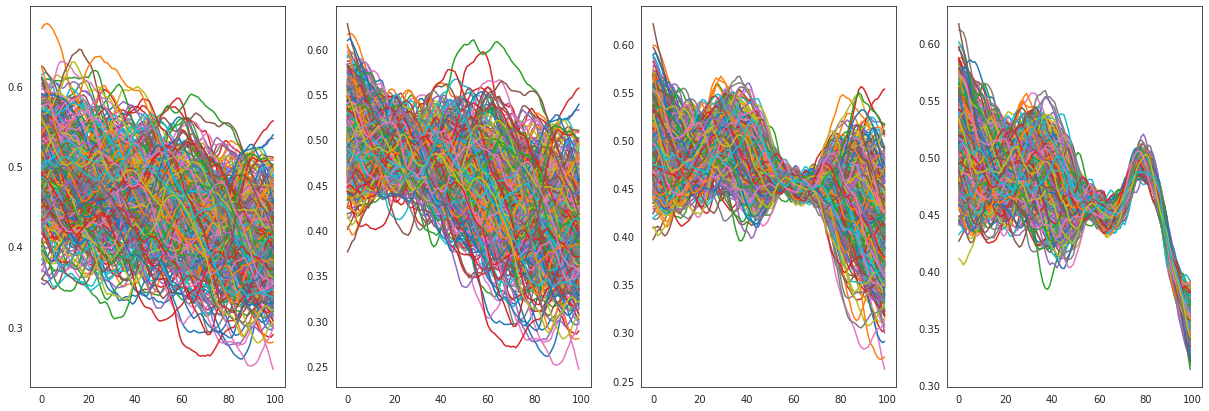

In [9]:
B = 400
x_asim = forecast_ensemble(t,B,n,1)
plot_asim(x_asim)

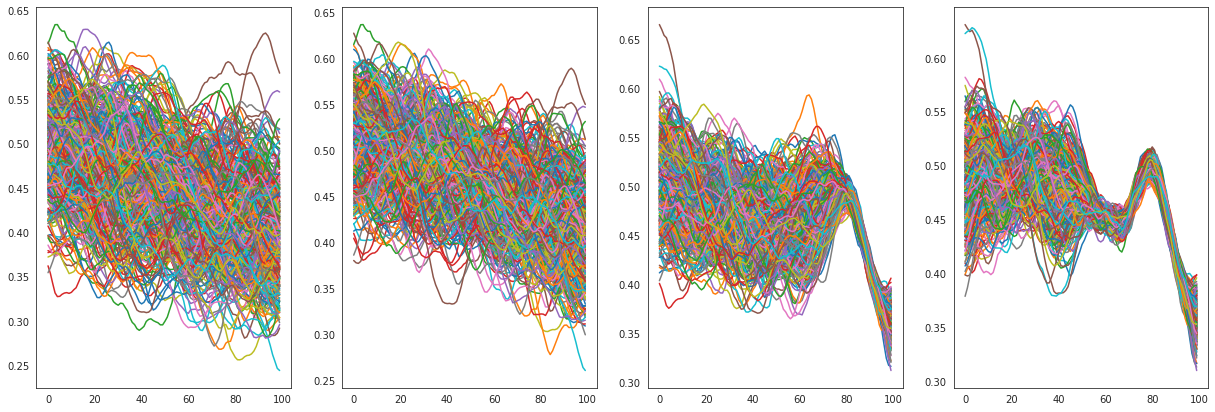

In [10]:
B = 400
x_asim = forecast_ensemble(t,B,n,-1)
plot_asim(x_asim)

Because the ensemble size is large, we observe small differences between the seeds. Thus, it is safe to say that when the ensemble size increases, the ensemble Kalman filter becomes more robust to ensemble members that are outliers. However, the filter becomes more computationally demanding, as the computation of the empirical covariance matrix $\Sigma_{x,t_j}$ becomes more challenging.

# c)

Since the forward model is linear, and the since the prior and the measurement noise are assumed Gaussian, Kalman filter yields an analytical solution to the filtering problem.

The prior distribution in the Kalman filter is assumed to be the same as for the ensemble Kalman filter. The Kalman gain is calculated as follows:
\begin{equation}
K = \Sigma_{j-1}g_j^T/(g_j\Sigma_{j-1}g_j^T+\tau^2),
\end{equation}
where $g_j = (1, \dots 1, 0, \dots 0)/\cos(\theta_j)$ is an $n\times 1$-vector. The first $j$ elements of $g_j$ are 1, while the remaining $n-j$ elements are 0. 

In contrary to the ensemble Kalman filter, we do not update the ensemble members $x^b$, but instead the parameters of the distribution for the slowness:
\begin{align*}
\mu_j &= \mu_{j-1}+K(t_j-g_j\mu_{j-1})\\
\Sigma_j &= \Sigma_{j-1}-K g_j \Sigma_{j-1}.
\end{align*}

The plot below shows the 80% prediction interval and with the analytical mean along with the ensemble-based solution for $B=200$.

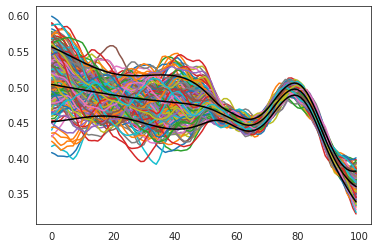

In [11]:
def kalman_filter(t, n):
    theta = np.cos(np.arctan(40/np.linspace(51,n,50)))
    sigma = 0.05
    tau = 0.1
    mu = 0.5-0.001*np.linspace(1,n,num = n)
    covar = np.identity(n)*sigma**2
    eta = 0.1
    
    for i in range(n-1):
        for j in range(i+1,n):
            h = abs(i-j)
            covar[i,j] = covar[j,i] = sigma**2*(1+eta*h)*np.exp(-eta*h)
            
    K = np.zeros(n)
    for j in range(50):
        g_j = np.concatenate((np.ones(j+51)/theta[j],np.zeros(n-j-51)))
        K = covar@np.transpose(g_j)/(g_j@covar@np.transpose(g_j)+tau**2) 
        mu = mu + K*(t[j]-g_j@mu)
        covar = covar - np.outer(K,np.matmul(g_j,covar))
        
    return(mu, covar) 



B = 200
n = 100

def compare_solutions(t,n,B,direction):
    mu, covar = kalman_filter(t, n)
    quantile = 1.28

    lower_bound = mu-quantile*np.sqrt(covar.diagonal())
    upper_bound = mu+quantile*np.sqrt(covar.diagonal())
    x_asim = forecast_ensemble(t,B,n,direction)
    plt.plot(x_asim[:,:,3].transpose())
    plt.plot(mu,'k')
    plt.plot(upper_bound,'k')
    plt.plot(lower_bound,'k')
    plt.show()


compare_solutions(t,n,B,1)

The black lines shows the mean and the bounds of the 80 % prediction interval. We observe that the vast majority of the ensemble members are contained in the prediction interval. Ideally, 80 % of the ensemble members should be contained in the interval. 

It should be noted that also the analytical prediction interval becomes more narrow in the area where data are present, i.e. at the depths $[51, 100]$. This is very intuitive; since data are present in this area, we are less uncertain in our predictions.

The plot below shows the analytical solution to the filtering problem along with the backward assimilation of the data.

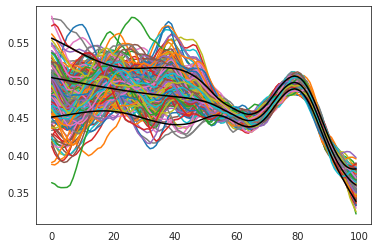

In [12]:
compare_solutions(t,n,B,-1)

This plot looks quite similar to the plot above. Let's now have a look at the forward and backward assimilations for $B=50$ and $B=400$.

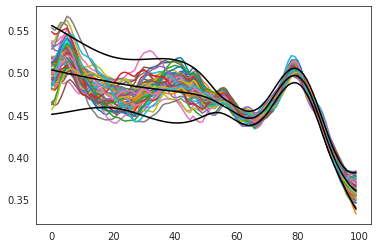

In [13]:
B = 50 
compare_solutions(t,n,B,1)

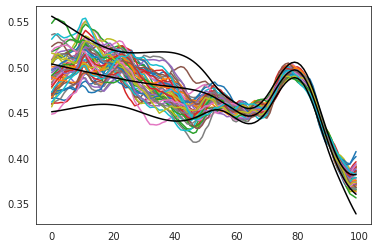

In [14]:
B = 50 
compare_solutions(t,n,B,-1)

Here we notice that the ensemble members not always are contained in the 80 % prediction interval. This varies from seed to seed.

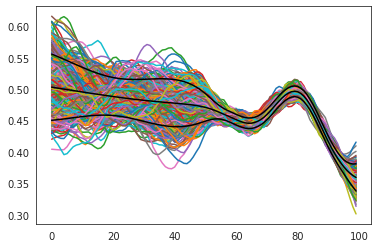

In [15]:
B = 400 
compare_solutions(t,n,B,1)

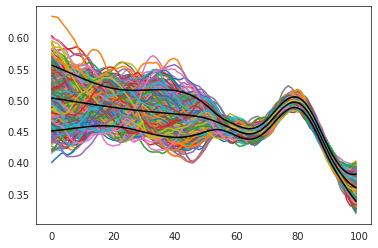

In [16]:
B = 400 
compare_solutions(t,n,B,-1)

For $B=400$ the ensemble members are quite stabile; no major differences from seed to seed. We notice the vast majority of the ensemble members are contained in the prediction interval, as expected. 